# CS6140 Final Project: Fake News Detection
## Part 1: Data Preprocessing & Exploratory Data Analysis

**Team Members**: <br>
Yu Ma: Data Acqusitions, Preprocessing and Exploratory Data Analysis (EDA);<br>
Zhixuan Shen;<br>
Ziyue Shen; <br>
Yaohui Wang  


In [22]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [23]:
import kagglehub
import os

# Download latest version
dataset_path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

print("Path to dataset files:", dataset_path)

Using Colab cache for faster access to the 'fake-news-detection-datasets' dataset.
Path to dataset files: /kaggle/input/fake-news-detection-datasets


In [24]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

print("✓ NLTK data downloaded!")

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# For better display in Jupyter
%matplotlib inline

✓ NLTK data downloaded!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [25]:
prefix = dataset_path + "/News _dataset/"

## Data Loading

In [26]:
# File paths - UPDATE THESE TO YOUR LOCAL PATHS
FAKE_PATH = prefix + 'Fake.csv'
TRUE_PATH = prefix + 'True.csv'

print("Dataset paths:")
print(f"  Fake news: {FAKE_PATH}")
print(f"  True news: {TRUE_PATH}")

# Load fake news dataset
df_fake = pd.read_csv(FAKE_PATH)
df_fake['label'] = 0  # 0 for fake
print(f"✓ Loaded {len(df_fake):,} fake news articles")
print(f"  Columns: {list(df_fake.columns)}")

# Load true news dataset
df_true = pd.read_csv(TRUE_PATH)
df_true['label'] = 1  # 1 for true
print(f"✓ Loaded {len(df_true):,} true news articles")
print(f"  Columns: {list(df_true.columns)}")

# Combine both datasets
df_raw = pd.concat([df_fake, df_true], axis=0, ignore_index=True)
print(f"\n✓ Combined dataset: {len(df_raw):,} total articles")
print(f"  Shape: {df_raw.shape}")

Dataset paths:
  Fake news: /kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv
  True news: /kaggle/input/fake-news-detection-datasets/News _dataset/True.csv
✓ Loaded 23,481 fake news articles
  Columns: ['title', 'text', 'subject', 'date', 'label']
✓ Loaded 21,417 true news articles
  Columns: ['title', 'text', 'subject', 'date', 'label']

✓ Combined dataset: 44,898 total articles
  Shape: (44898, 5)


### Initial Data Inspection

In [27]:
# Display first few rows
print("First 3 rows of the dataset:")
df_raw.head(3)

# Dataset information
print("Dataset Info:")
df_raw.info()

# Class distribution
print("Class Distribution:")
print(df_raw['label'].value_counts())
print(f"\nFake (0): {(df_raw['label']==0).sum():,} ({(df_raw['label']==0).sum()/len(df_raw)*100:.2f}%)")
print(f"True (1): {(df_raw['label']==1).sum():,} ({(df_raw['label']==1).sum()/len(df_raw)*100:.2f}%)")

# Check for missing values
print("Missing Values:")
missing = df_raw.isnull().sum()
print(missing[missing > 0])
print(f"\nTotal missing values: {df_raw.isnull().sum().sum()}")

# Subject distribution
print("Subject Distribution:")
print(df_raw['subject'].value_counts())

First 3 rows of the dataset:
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
Class Distribution:
label
0    23481
1    21417
Name: count, dtype: int64

Fake (0): 23,481 (52.30%)
True (1): 21,417 (47.70%)
Missing Values:
Series([], dtype: int64)

Total missing values: 0
Subject Distribution:
subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


In [28]:
# Sample articles
print("Sample Fake News Article:")
print("="*80)
fake_sample = df_raw[df_raw['label']==0].iloc[0]
print(f"Title: {fake_sample['title']}")
print(f"Text: {fake_sample['text'][:300]}...")
print(f"Subject: {fake_sample['subject']}")
print(f"Date: {fake_sample['date']}")

print("\n" + "="*80)
print("Sample True News Article:")
print("="*80)
true_sample = df_raw[df_raw['label']==1].iloc[0]
print(f"Title: {true_sample['title']}")
print(f"Text: {true_sample['text'][:300]}...")
print(f"Subject: {true_sample['subject']}")
print(f"Date: {true_sample['date']}")

Sample Fake News Article:
Title:  Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
Text: Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger a...
Subject: News
Date: December 31, 2017

Sample True News Article:
Title: As U.S. budget fight looms, Republicans flip their fiscal script
Text: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way ...
Subject: politicsNews
Date: December 31, 2017 


## Data Preprocessing

### Define Text Cleaning Function

In [29]:
def clean_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text) # Remove email addresses
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

print("✓ Text cleaning function defined")

# Test the cleaning function
test_text = "Check out this article at https://example.com! It's #Amazing... 123"
cleaned = clean_text(test_text)
print(f"Original: {test_text}")
print(f"Cleaned:  {cleaned}")

✓ Text cleaning function defined
Original: Check out this article at https://example.com! It's #Amazing... 123
Cleaned:  check out this article at its amazing


### Handle Missing Values

In [30]:
# Create a copy for processing
df = df_raw.copy()

initial_missing = df['title'].isna().sum() + df['text'].isna().sum()
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

print(f"✓ Filled {initial_missing} missing values in title and text columns")

✓ Filled 0 missing values in title and text columns


### Combine Title and Text

In [31]:
# Combine title and text
df['full_text'] = df['title'] + ' ' + df['text']
print(f"✓ Created 'full_text' column")
print(f"  Sample length: {len(df['full_text'].iloc[0])} characters")

✓ Created 'full_text' column
  Sample length: 2973 characters


### Clean All Text

In [32]:
print("Cleaning text... (this may take 1-2 minutes)")
df['cleaned_text'] = df['full_text'].apply(clean_text)
print("✓ Text cleaning complete!")

sample_idx = 0
print("Before cleaning:")
print(df['full_text'].iloc[sample_idx][:200])
print("\n" + "="*80 + "\n")
print("After cleaning:")
print(df['cleaned_text'].iloc[sample_idx][:200])

Cleaning text... (this may take 1-2 minutes)
✓ Text cleaning complete!
Before cleaning:
 Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out


After cleaning:
donald trump sends out embarrassing new years eve message this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to h


### Remove Stopwords

In [33]:
REMOVE_STOPWORDS = True

if REMOVE_STOPWORDS:
    print("Removing stopwords...")
    stop_words = set(stopwords.words('english'))

    def remove_stopwords(text):
        if not text:
            return ""
        words = text.split()
        filtered_words = [word for word in words if word not in stop_words]
        return ' '.join(filtered_words)

    df['processed_text'] = df['cleaned_text'].apply(remove_stopwords)
    print("✓ Stopwords removed")
else:
    df['processed_text'] = df['cleaned_text']
    print("✓ Keeping stopwords (recommended for BERT)")


# Count empty texts
empty_count = (df['processed_text'].str.strip() == '').sum()
print(f"Found {empty_count} empty texts")

# Remove empty texts
df = df[df['processed_text'].str.strip() != '']
df = df.reset_index(drop=True)

print(f"✓ Final dataset size: {len(df):,} articles")

Removing stopwords...
✓ Stopwords removed
Found 9 empty texts
✓ Final dataset size: 44,889 articles


### Create Additional Features

In [34]:
# Create length features
df['text_length'] = df['processed_text'].apply(len)
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))

print("✓ Created length features:")
print(f"  - text_length: character count")
print(f"  - word_count: word count")

# Process date information
try:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    print("✓ Extracted year and month from dates")
    print(f"  Date range: {df['year'].min()} - {df['year'].max()}")
except:
    print("⚠ Could not parse dates")

# Display processed dataset info
print("\nProcessed Dataset Summary:")
print("="*80)
print(f"Total articles: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"\nSample statistics:")
print(df[['text_length', 'word_count', 'label']].describe())

✓ Created length features:
  - text_length: character count
  - word_count: word count
✓ Extracted year and month from dates
  Date range: 2015.0 - 2017.0

Processed Dataset Summary:
Total articles: 44,889
Columns: ['title', 'text', 'subject', 'date', 'label', 'full_text', 'cleaned_text', 'processed_text', 'text_length', 'word_count', 'year', 'month']

Sample statistics:
        text_length    word_count         label
count  44889.000000  44889.000000  44889.000000
mean    1788.762525    237.586313      0.477110
std     1535.748066    199.106938      0.499481
min       22.000000      3.000000      0.000000
25%      927.000000    125.000000      0.000000
50%     1573.000000    210.000000      0.000000
75%     2212.000000    295.000000      1.000000
max    38745.000000   4854.000000      1.000000


---
## Exploratory Data Analysis - EDS

### Class Distribution

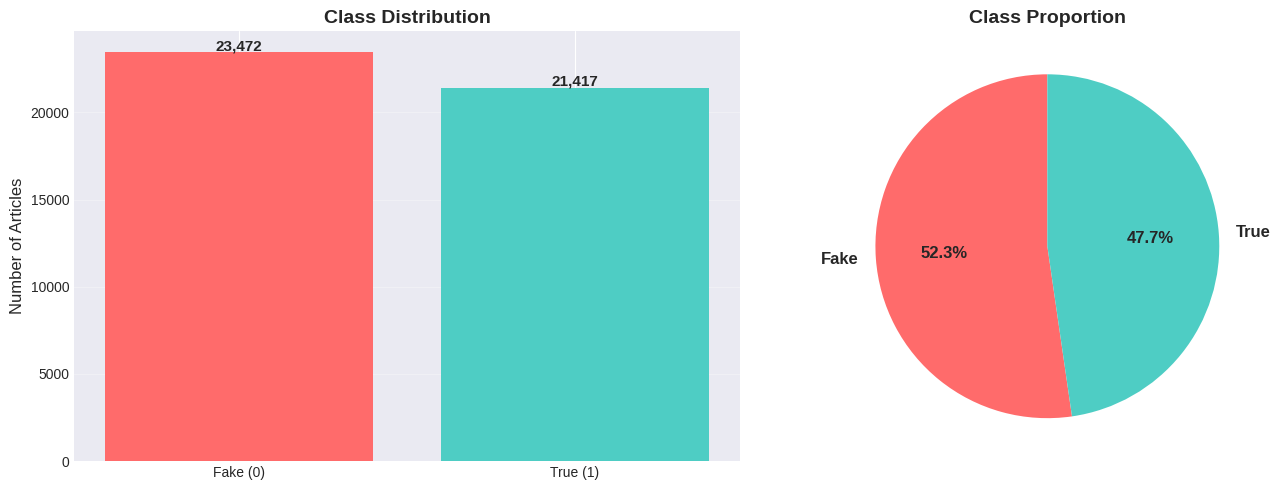

✓ Figure saved: fig1_class_distribution.png
Dataset is balanced


In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
counts = df['label'].value_counts()
axes[0].bar(['Fake (0)', 'True (1)'], counts.values, color=['#FF6B6B', '#4ECDC4'])
axes[0].set_ylabel('Number of Articles', fontsize=12)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold', fontsize=11)

# Pie chart
colors = ['#FF6B6B', '#4ECDC4']
axes[1].pie(counts.values, labels=['Fake', 'True'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('fig1_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved: fig1_class_distribution.png")
print(f"Dataset is {'balanced' if abs(counts[0]-counts[1])/len(df) < 0.1 else 'imbalanced'}")

### Text Length Analysis

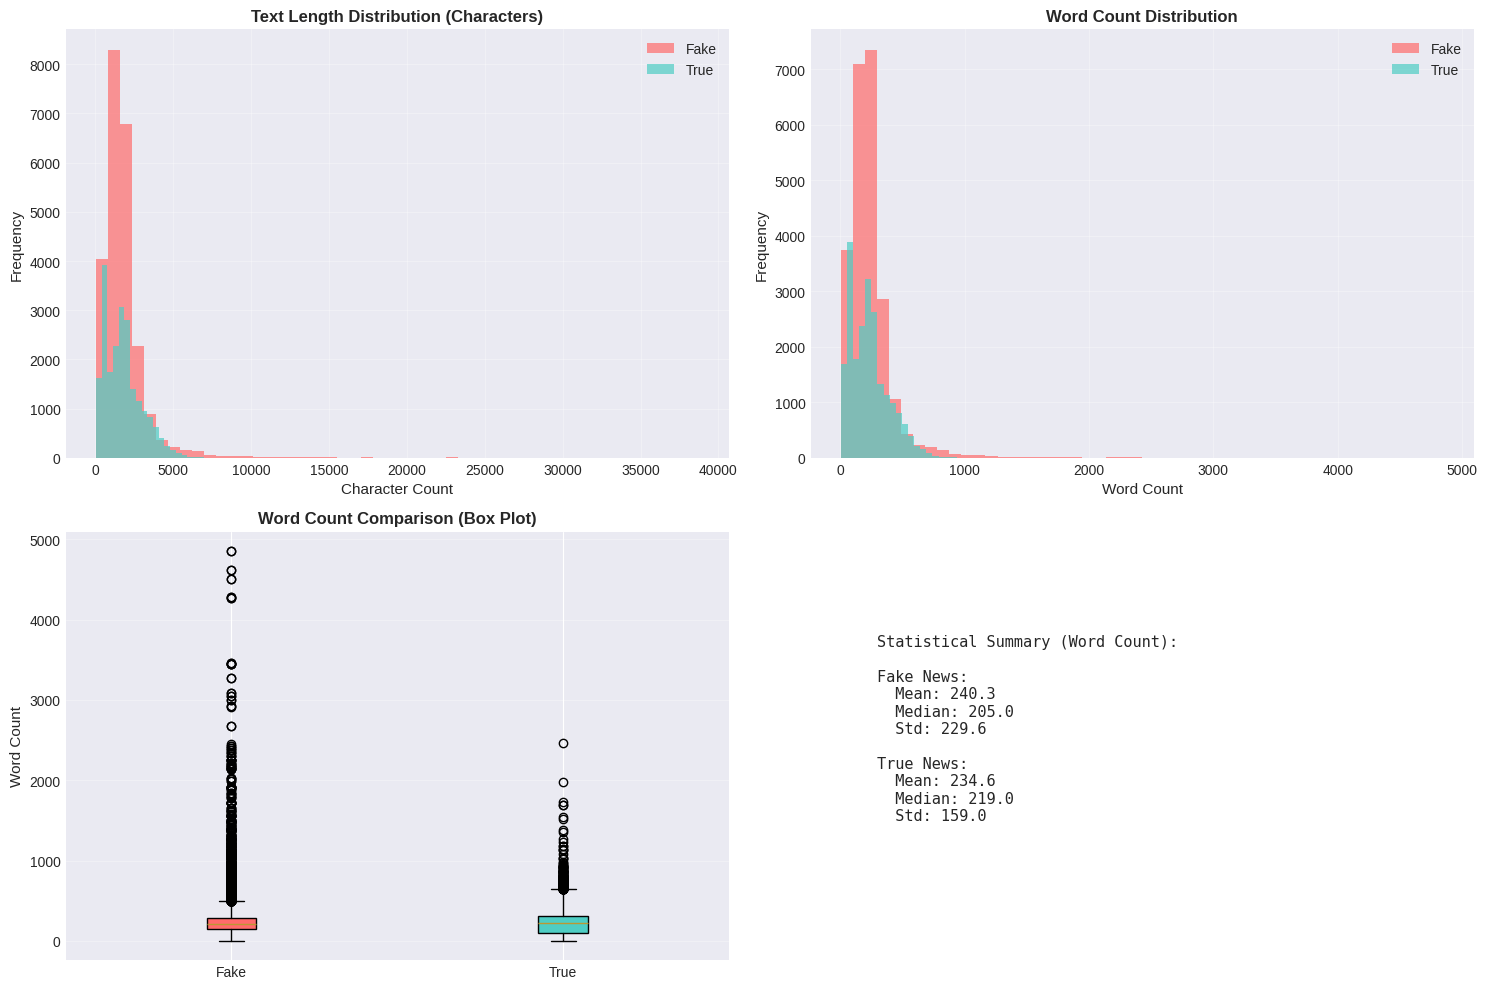

✓ Figure saved: fig2_text_length.png
Fake news avg: 240.3 words
True news avg: 234.6 words
Difference: 5.7 words


In [36]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Character length distribution by class
axes[0, 0].hist(df[df['label']==0]['text_length'], bins=50,
               alpha=0.7, label='Fake', color='#FF6B6B')
axes[0, 0].hist(df[df['label']==1]['text_length'], bins=50,
               alpha=0.7, label='True', color='#4ECDC4')
axes[0, 0].set_xlabel('Character Count', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Text Length Distribution (Characters)', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# 2. Word count distribution by class
axes[0, 1].hist(df[df['label']==0]['word_count'], bins=50,
               alpha=0.7, label='Fake', color='#FF6B6B')
axes[0, 1].hist(df[df['label']==1]['word_count'], bins=50,
               alpha=0.7, label='True', color='#4ECDC4')
axes[0, 1].set_xlabel('Word Count', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# 3. Box plot comparison
data_to_plot = [df[df['label']==0]['word_count'],
               df[df['label']==1]['word_count']]
bp = axes[1, 0].boxplot(data_to_plot, labels=['Fake', 'True'], patch_artist=True)
bp['boxes'][0].set_facecolor('#FF6B6B')
bp['boxes'][1].set_facecolor('#4ECDC4')
axes[1, 0].set_ylabel('Word Count', fontsize=11)
axes[1, 0].set_title('Word Count Comparison (Box Plot)', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Statistical summary
stats_text = "Statistical Summary (Word Count):\n\n"
for label, name in [(0, 'Fake'), (1, 'True')]:
    data = df[df['label']==label]['word_count']
    stats_text += f"{name} News:\n"
    stats_text += f"  Mean: {data.mean():.1f}\n"
    stats_text += f"  Median: {data.median():.1f}\n"
    stats_text += f"  Std: {data.std():.1f}\n\n"

axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
               verticalalignment='center')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('fig2_text_length.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved: fig2_text_length.png")
fake_mean = df[df['label']==0]['word_count'].mean()
true_mean = df[df['label']==1]['word_count'].mean()
print(f"Fake news avg: {fake_mean:.1f} words")
print(f"True news avg: {true_mean:.1f} words")
print(f"Difference: {abs(fake_mean-true_mean):.1f} words")

### Subject Distribution

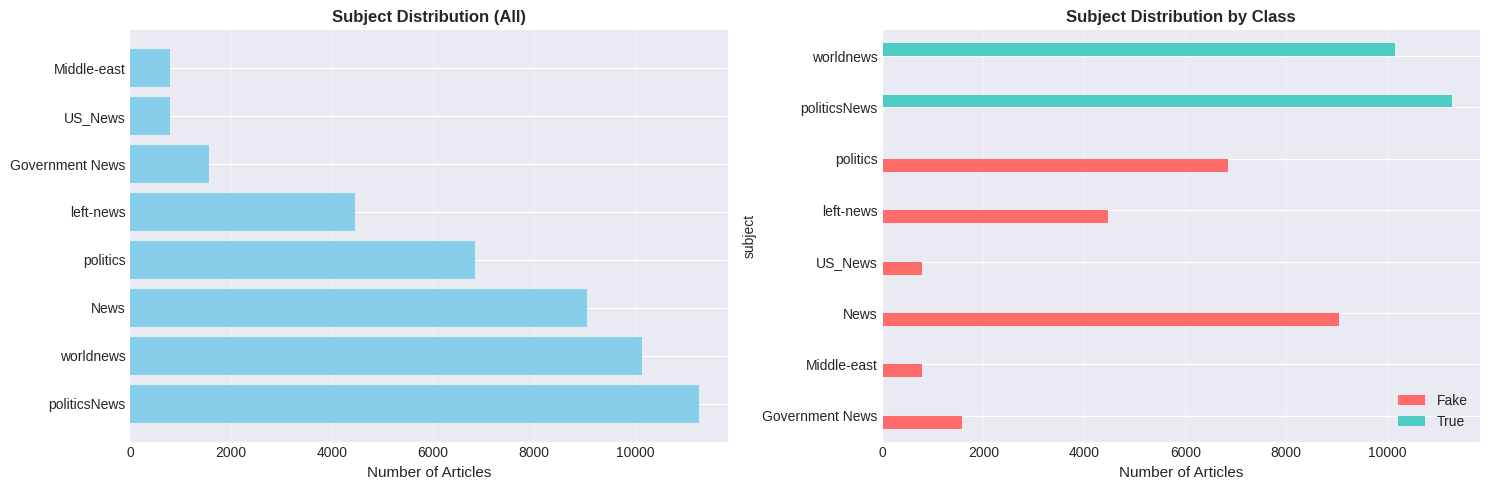

✓ Figure saved: fig3_subject_distribution.png
Found 8 different subjects
Most common: politicsNews (11,272 articles)


In [37]:
if 'subject' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Overall subject distribution
    subject_counts = df['subject'].value_counts()
    axes[0].barh(subject_counts.index, subject_counts.values, color='skyblue')
    axes[0].set_xlabel('Number of Articles', fontsize=11)
    axes[0].set_title('Subject Distribution (All)', fontsize=12, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)

    # Subject distribution by class
    subject_by_label = pd.crosstab(df['subject'], df['label'])
    subject_by_label.plot(kind='barh', stacked=False, ax=axes[1],
                         color=['#FF6B6B', '#4ECDC4'])
    axes[1].set_xlabel('Number of Articles', fontsize=11)
    axes[1].set_title('Subject Distribution by Class', fontsize=12, fontweight='bold')
    axes[1].legend(['Fake', 'True'], fontsize=10)
    axes[1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('fig3_subject_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Figure saved: fig3_subject_distribution.png")
    print(f"Found {len(subject_counts)} different subjects")
    print(f"Most common: {subject_counts.index[0]} ({subject_counts.values[0]:,} articles)")
else:
    print("⚠ No 'subject' column found")

### Temporal Analysis

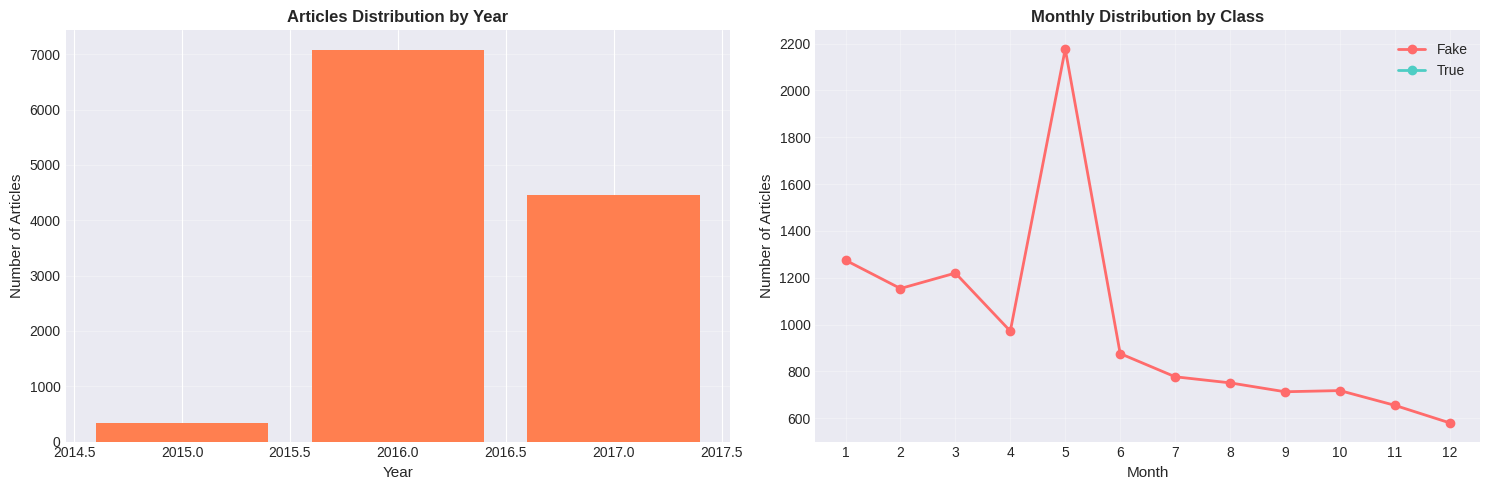

✓ Figure saved


In [38]:
if 'year' in df.columns and 'month' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Articles by year
    year_counts = df['year'].value_counts().sort_index()
    axes[0].bar(year_counts.index, year_counts.values, color='coral')
    axes[0].set_xlabel('Year', fontsize=11)
    axes[0].set_ylabel('Number of Articles', fontsize=11)
    axes[0].set_title('Articles Distribution by Year', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

    # Articles by month (for each class)
    for label, color, name in [(0, '#FF6B6B', 'Fake'), (1, '#4ECDC4', 'True')]:
        month_data = df[df['label']==label]['month'].value_counts().sort_index()
        axes[1].plot(month_data.index, month_data.values, marker='o',
                    label=name, color=color, linewidth=2)

    axes[1].set_xlabel('Month', fontsize=11)
    axes[1].set_ylabel('Number of Articles', fontsize=11)
    axes[1].set_title('Monthly Distribution by Class', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(alpha=0.3)
    axes[1].set_xticks(range(1, 13))

    plt.tight_layout()
    plt.savefig('fig4_temporal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Figure saved")
else:
    print("⚠ No date information available")

### Word Clouds

Generating word clouds... (this may take 1-2 minutes)


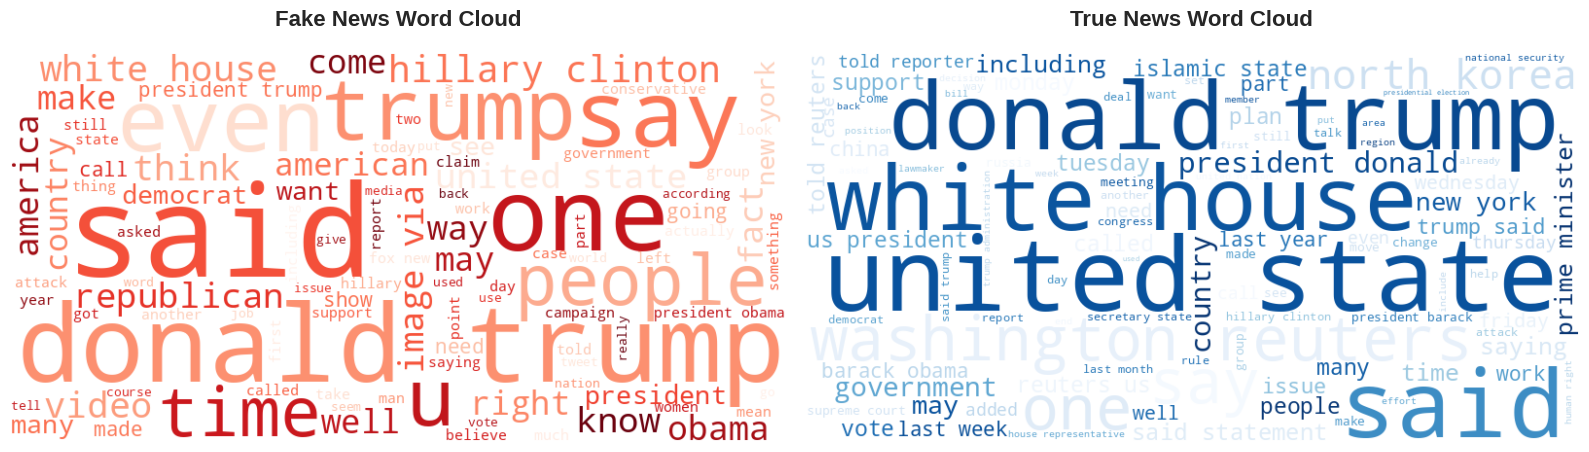

✓ Figure saved


In [39]:
print("Generating word clouds... (this may take 1-2 minutes)")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fake news word cloud
fake_text = ' '.join(df[df['label']==0]['processed_text'].values)
wordcloud_fake = WordCloud(width=800, height=400,
                           background_color='white',
                           colormap='Reds',
                           max_words=100).generate(fake_text)

axes[0].imshow(wordcloud_fake, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Fake News Word Cloud', fontsize=16, fontweight='bold', pad=20)

# True news word cloud
true_text = ' '.join(df[df['label']==1]['processed_text'].values)
wordcloud_true = WordCloud(width=800, height=400,
                           background_color='white',
                           colormap='Blues',
                           max_words=100).generate(true_text)

axes[1].imshow(wordcloud_true, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('True News Word Cloud', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('fig5_wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved")

### Top Words Analysis

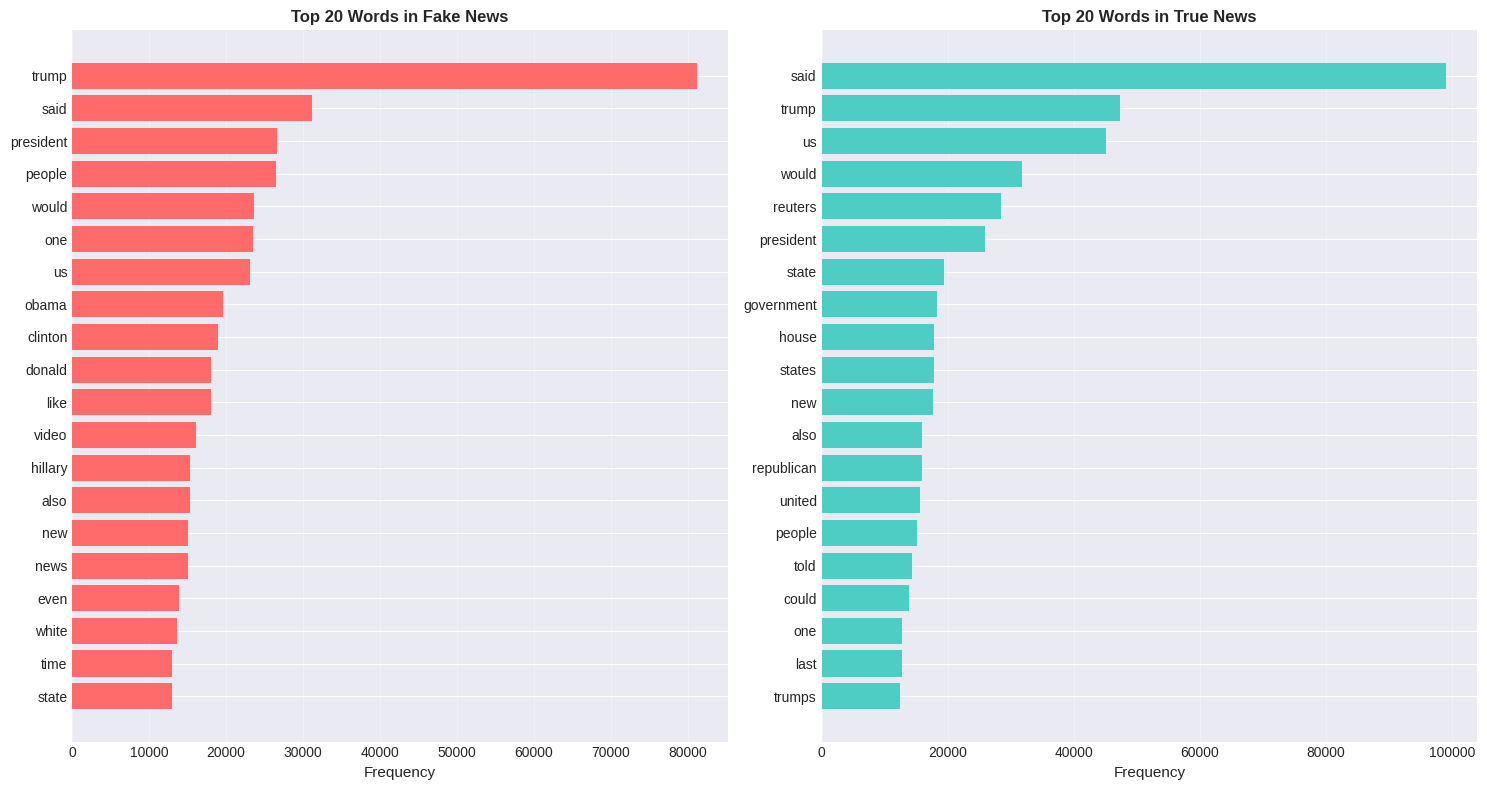

In [40]:
n_words = 20
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

for idx, (label, color, name) in enumerate([(0, '#FF6B6B', 'Fake'),
                                              (1, '#4ECDC4', 'True')]):
    text_data = df[df['label']==label]['processed_text']
    all_words = ' '.join(text_data.values).split()
    word_freq = Counter(all_words)

    # Get top N words
    top_words = word_freq.most_common(n_words)
    words, counts = zip(*top_words)

    axes[idx].barh(range(len(words)), counts, color=color)
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words, fontsize=10)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Top {n_words} Words in {name} News', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('fig6_top_words.png', dpi=300, bbox_inches='tight')
plt.show()

### Correlation Analysis

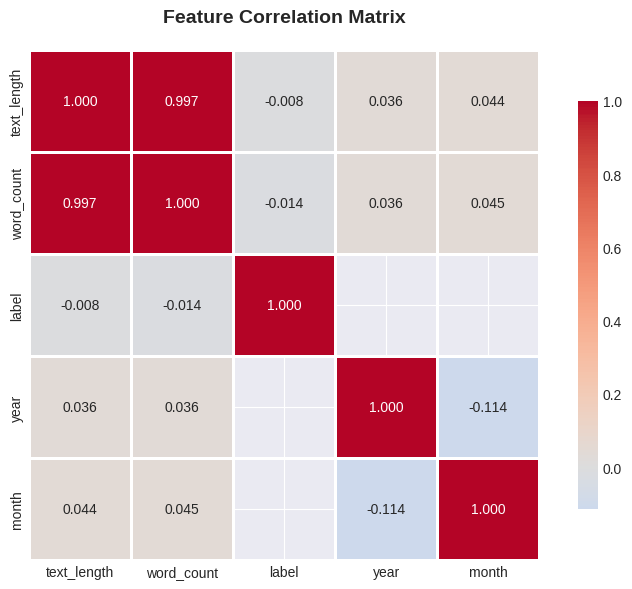

In [41]:
numerical_cols = ['text_length', 'word_count', 'label']
if 'year' in df.columns:
    numerical_cols.append('year')
if 'month' in df.columns:
    numerical_cols.append('month')

corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
           center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('fig7_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


### Summary Statistics Report

In [42]:
print(" Summary Statistics Report".center(80, "="))

print("\n1. Dataset Overview")
print(f"   Total articles: {len(df):,}")
print(f"   Fake articles: {(df['label']==0).sum():,} ({(df['label']==0).sum()/len(df)*100:.2f}%)")
print(f"   True articles: {(df['label']==1).sum():,} ({(df['label']==1).sum()/len(df)*100:.2f}%)")

print("\n2. Text Length Statistics")
for label, name in [(0, 'Fake'), (1, 'True')]:
    data = df[df['label']==label]
    print(f"\n   {name} News:")
    print(f"      Avg characters: {data['text_length'].mean():.1f}")
    print(f"      Avg words: {data['word_count'].mean():.1f}")
    print(f"      Min words: {data['word_count'].min()}")
    print(f"      Max words: {data['word_count'].max()}")

if 'subject' in df.columns:
    print("\n3. subjext distrubution")
    subject_counts = df['subject'].value_counts()
    for subject, count in subject_counts.items():
        print(f"   {subject}: {count:,} ({count/len(df)*100:.1f}%)")

if 'year' in df.columns:
    print("\n4. Temporal Coverage")
    print(f"   Year range: {df['year'].min():.0f} - {df['year'].max():.0f}")
    print(f"   Most articles in: {df['year'].mode()[0]:.0f}")


=========================== Summary Statistics Report===========================

1. Dataset Overview
   Total articles: 44,889
   Fake articles: 23,472 (52.29%)
   True articles: 21,417 (47.71%)

2. Text Length Statistics

   Fake News:
      Avg characters: 1800.6
      Avg words: 240.3
      Min words: 3
      Max words: 4854

   True News:
      Avg characters: 1775.8
      Avg words: 234.6
      Min words: 4
      Max words: 2460

3. subjext distrubution
   politicsNews: 11,272 (25.1%)
   worldnews: 10,145 (22.6%)
   News: 9,050 (20.2%)
   politics: 6,836 (15.2%)
   left-news: 4,457 (9.9%)
   Government News: 1,568 (3.5%)
   US_News: 783 (1.7%)
   Middle-east: 778 (1.7%)

4. Temporal Coverage
   Year range: 2015 - 2017
   Most articles in: 2016


## Part 2: Model Training

In [43]:
# drop samples with very short texts (less than 30 words)
df = df[df['word_count'] >= 30].reset_index(drop=True)
# remove reuters prefixes (all true news from Reuters have this prefix)
def remove_reuters_prefix(text):
    pattern = r'^.*?\(Reuters\) - '
    cleaned_text = re.sub(pattern, '', text.strip())
    return cleaned_text
def remove_reuters_mention(text):
    pattern = r'Reuters'
    cleaned_text = re.sub(pattern, '', text.strip())
    return cleaned_text
# remove last sentence if it contains certain keywords
def remove_last_sentence_with_keywords(text):
    sentence_separators = r'([.!?\n])'
    parts = re.split(sentence_separators, text.strip())

    sentences = []
    current_sentence = ""
    for part in parts:
        current_sentence += part
        if part in ['.', '!', '?', '\n']:
            sentences.append(current_sentence.strip())
            current_sentence = ""

    if current_sentence.strip() != "":
        sentences.append(current_sentence.strip())

    if len(sentences) == 0:
        return text.strip()

    last_sentence = sentences[-1]
    keywords = ['via', 'image', 'Image', 'video', 'Images', ':']

    keyword_pattern = r'\b(' + '|'.join(re.escape(k) for k in keywords) + r')\b'
    has_keyword = re.search(keyword_pattern, last_sentence, flags=re.IGNORECASE)

    if has_keyword:
        cleaned_text = ' '.join(sentences[:-1]).strip()
        return cleaned_text if cleaned_text else ""
    else:
        return text.strip()

#remove 21st Century Wire mentions
def remove_21st_century_wire_mention(text):
    pattern = r'21st Century Wire'
    cleaned_text = re.sub(pattern, '', text.strip())
    return cleaned_text


# other preprocessing steps
df['text'] = df['text'].apply(remove_reuters_prefix)
df['text'] = df['text'].apply(remove_reuters_mention)
df['text'] = df['text'].apply(remove_last_sentence_with_keywords)
df['text'] = df['text'].apply(remove_21st_century_wire_mention)
df['cleaned_text'] = df['text'].apply(clean_text)
df['processed_text'] = df['cleaned_text'].apply(remove_stopwords)

In [44]:
# get some samples from each class
df_fake_samples = df[df['label']==0].sample(3, random_state=42)
df_true_samples = df[df['label']==1].sample(3, random_state=42)
# display samples
print("Sample Fake News Articles:")
for idx, row in df_fake_samples.iterrows():
    print("\n" + "-"*80)
    print(f"Text: {row['processed_text'][:300]}...")

print("\nSample True News Articles:")
for idx, row in df_true_samples.iterrows():
    print("\n" + "-"*80)
    print(f"Text: {row['processed_text'][:300]}...")

Sample Fake News Articles:

--------------------------------------------------------------------------------
Text: donald trump jr took twitter today release email communication kremlinlinked lawyer revealing hoped get hands information would damage hillary clinton campaign really news someone donald trump jr knew wanted help revealing dirt hillary trump jr agreed meet okay would hillary camp declined meeting ro...

--------------------------------------------------------------------------------
Text: david sherfinski washington timesformer texas rep ron paul said friday support gop presidential frontrunner donald trump mr trump wins party nomination saying mr trump views scope executive authority could surpass president obama mr paul said fox business network asked would support mr trump billion...

--------------------------------------------------------------------------------
Text: first time lives entering era elected president downright dangerous donald trump petty childish ignor

In [45]:
# split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [46]:
# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### Logistic Regression (benchmark)

In [47]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Model training
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)
# Prediction
y_pred = model.predict(X_test_vec)
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9805


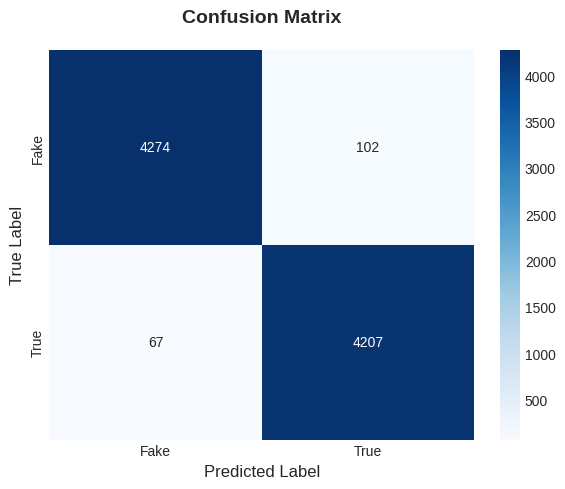

In [48]:
# visualize confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('fig8_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
# visualize core features
# Use get_feature_names_out() for sklearn >= 1.0, fallback to get_feature_names() for older versions
try:
    feature_names = vectorizer.get_feature_names_out()
except AttributeError:
    feature_names = vectorizer.get_feature_names()
coefficients = model.coef_[0]
# Get top positive and negative features
top_positive_indices = np.argsort(coefficients)[-20:]
top_negative_indices = np.argsort(coefficients)[:20]
top_positive_features = [(feature_names[i], coefficients[i]) for i in top_positive_indices]
top_negative_features = [(feature_names[i], coefficients[i]) for i in top_negative_indices]
print("Top 20 Positive Features:")
for feature, coef in reversed(top_positive_features):
    print(f"  {feature}: {coef:.4f}")
print("\nTop 20 Negative Features:")
for feature, coef in top_negative_features:
    print(f"  {feature}: {coef:.4f}")

Top 20 Positive Features:
  said: 18.1917
  trumps: 12.4433
  us: 8.0680
  wednesday: 6.4107
  tuesday: 5.9005
  thursday: 5.8505
  friday: 5.3728
  dont: 4.9616
  republican: 4.6662
  monday: 4.5070
  clintons: 4.4380
  nov: 4.4152
  im: 4.4073
  reporters: 4.3887
  obamas: 4.2253
  thats: 4.0823
  minister: 4.0193
  presidential: 3.8523
  edt: 3.8477
  told: 3.5634

Top 20 Negative Features:
  obama: -5.8217
  gop: -5.5264
  america: -5.3888
  even: -5.3818
  mr: -5.1048
  rep: -4.6877
  hillary: -4.3318
  like: -4.3086
  american: -4.2519
  sen: -3.9443
  trump: -3.7687
  read: -3.5423
  isis: -3.5326
  watch: -3.3996
  know: -3.3694
  fact: -3.3407
  story: -3.2331
  says: -3.2210
  today: -3.1982
  press: -3.1955


### Naive Bayes

In [50]:
from sklearn.naive_bayes import MultinomialNB
# Model training
nb_model = MultinomialNB(alpha=1.0)  # alpha is the smoothing parameter
nb_model.fit(X_train_vec, y_train)

# Prediction
y_pred = nb_model.predict(X_test_vec)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {accuracy:.4f}")

Naive Bayes Accuracy: 0.9273


In [51]:
from sklearn.model_selection import GridSearchCV
# Hyperparameter tuning for Naive Bayes
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]
}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec, y_train)
best_nb_model = grid_search.best_estimator_
print(f"Best alpha: {grid_search.best_params_['alpha']}")
# Prediction with best model
y_pred = best_nb_model.predict(X_test_vec)
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Tuned Naive Bayes Accuracy: {accuracy:.4f}")

Best alpha: 0.1
Tuned Naive Bayes Accuracy: 0.9296


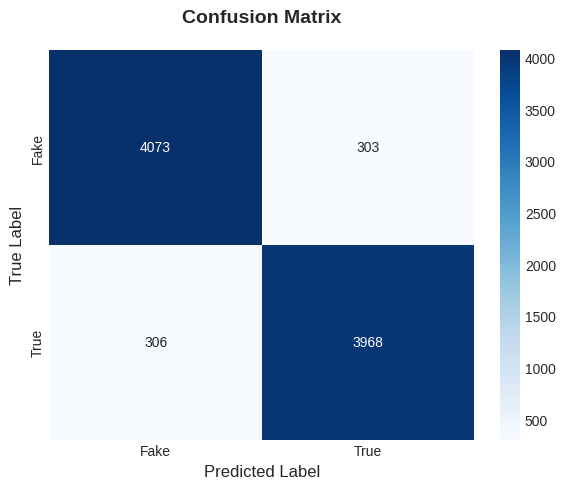

In [52]:
# visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('fig8_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
# visualize core features
try:
    feature_names = vectorizer.get_feature_names_out()
except AttributeError:
    feature_names = vectorizer.get_feature_names()
# For MultinomialNB, use feature_log_prob_ instead of coef_
# We can approximate feature importance by the difference in log probabilities for each class
coefficients = best_nb_model.feature_log_prob_[1] - best_nb_model.feature_log_prob_[0]
# Get top positive and negative features
top_positive_indices = np.argsort(coefficients)[-20:]
top_negative_indices = np.argsort(coefficients)[:20]
top_positive_features = [(feature_names[i], coefficients[i]) for i in top_positive_indices]
top_negative_features = [(feature_names[i], coefficients[i]) for i in top_negative_indices]
print("Top 20 Positive Features (More associated with True News):")
for feature, coef in reversed(top_positive_features):
    print(f"  {feature}: {coef:.4f}")
print("\nTop 20 Negative Features (More associated with Fake News):")
for feature, coef in top_negative_features:
    print(f"  {feature}: {coef:.4f}")

Top 20 Positive Features (More associated with True News):
  rohingya: 6.5521
  hariri: 6.0860
  rakhine: 5.9993
  myanmar: 5.9946
  puigdemont: 5.9263
  zuma: 5.8258
  partys: 5.7022
  mnangagwa: 5.6653
  fdp: 5.6153
  odinga: 5.6057
  catalan: 5.5592
  rajoy: 5.4974
  suu: 5.3808
  kurz: 5.3803
  kyi: 5.3654
  anc: 5.3500
  krg: 5.2593
  tuesdays: 5.2034
  barnier: 5.2016
  russias: 5.1760

Top 20 Negative Features (More associated with Fake News):
  acr: -6.3759
  pic: -6.1805
  wiretv: -6.0373
  js: -5.8631
  subscribe: -5.7527
  filessupport: -5.6349
  henningsen: -5.5013
  cdata: -5.4155
  reilly: -5.0365
  boiler: -4.9733
  finicum: -4.9313
  bundy: -4.7748
  cops: -4.6854
  hilarious: -4.4833
  shit: -4.4653
  maher: -4.3940
  fck: -4.3872
  pundit: -4.2809
  racists: -4.2634
  antifa: -4.2428


### Random Forest

In [54]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Model training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vec, y_train)
# Prediction
y_pred = rf_model.predict(X_test_vec)
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 0.9820


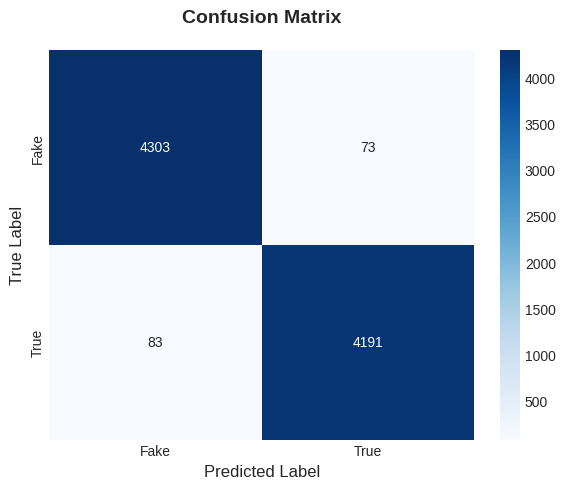

In [55]:
# visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('fig9_rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
# visualize core features
try:
    feature_names = vectorizer.get_feature_names_out()
except AttributeError:
    feature_names = vectorizer.get_feature_names()
importances = rf_model.feature_importances_
# Get top important features
top_indices = np.argsort(importances)[-20:]
top_features = [(feature_names[i], importances[i]) for i in top_indices]
print("Top 20 Important Features:")
for feature, imp in reversed(top_features):
    print(f"  {feature}: {imp:.4f}")


Top 20 Important Features:
  said: 0.0709
  trumps: 0.0214
  us: 0.0209
  minister: 0.0186
  like: 0.0165
  america: 0.0102
  know: 0.0101
  hillary: 0.0090
  tuesday: 0.0086
  even: 0.0084
  actually: 0.0081
  wednesday: 0.0078
  right: 0.0073
  friday: 0.0072
  get: 0.0070
  video: 0.0070
  really: 0.0066
  fact: 0.0066
  thursday: 0.0063
  trump: 0.0062


### LSTM Deep Learning

In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['processed_text'])

sequences = tokenizer.texts_to_sequences(df['processed_text'])

max_len = 400
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
y = df['label'].values

In [59]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [60]:
# Build LSTM model
vocab_size = 10000
embedding_dim = 128
lstm_units = 64

model = Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size,
                                    output_dim=embedding_dim,
                                    input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [61]:
# train the model
batch_size = 64
epochs = 5
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size)


Epoch 1/5
541/541 ━━━━━━━━━━━━━━━━━━━━ 293s 537ms/step - accuracy: 0.5764 - loss: 0.6569 - val_accuracy: 0.5587 - val_loss: 0.6705
Epoch 2/5
541/541 ━━━━━━━━━━━━━━━━━━━━ 318s 529ms/step - accuracy: 0.7099 - loss: 0.5291 - val_accuracy: 0.8957 - val_loss: 0.2721
Epoch 3/5
541/541 ━━━━━━━━━━━━━━━━━━━━ 285s 526ms/step - accuracy: 0.9284 - loss: 0.2103 - val_accuracy: 0.9487 - val_loss: 0.1395
Epoch 4/5
541/541 ━━━━━━━━━━━━━━━━━━━━ 282s 521ms/step - accuracy: 0.9704 - loss: 0.0987 - val_accuracy: 0.8919 - val_loss: 0.2631
Epoch 5/5
541/541 ━━━━━━━━━━━━━━━━━━━━ 284s 525ms/step - accuracy: 0.9061 - loss: 0.2179 - val_accuracy: 0.9749 - val_loss: 0.0889


In [62]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

271/271 ━━━━━━━━━━━━━━━━━━━━ 48s 178ms/step - accuracy: 0.9758 - loss: 0.0842
Test Loss: 0.08891179412603378
Test Accuracy: 0.9749132990837097


271/271 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step


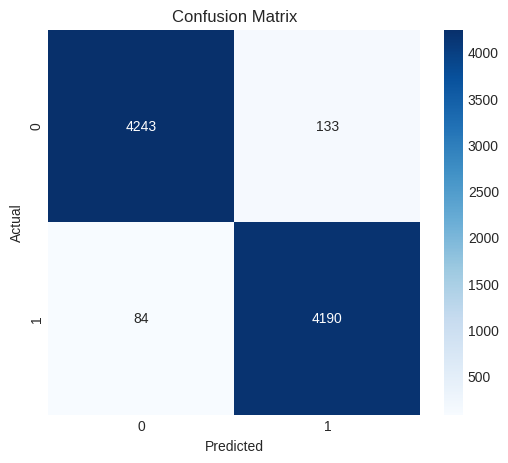

In [63]:
from sklearn.metrics import confusion_matrix
# visualize confusion matrix
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Part 4


 PART 4: COMPREHENSIVE MODEL EVALUATION 
Test Set Size: 8,650 samples

[1/4] Vectorizing data for classical models...
[2/4] Training and evaluating classical models...
  -> Logistic Regression done (Acc: 0.9805)
  -> Naive Bayes done (Acc: 0.9296)
  -> Random Forest done (Acc: 0.9820)

[3/4] Evaluating LSTM model...
  -> LSTM done (Acc: 0.9749)

[4/4] Generating comparative plots and reports...

=== FINAL PERFORMANCE LEADERBOARD ===


,accuracy,precision,recall,f1,roc_auc
model,,,,,
Random Forest,0.9820,0.9829,0.9806,0.9817,0.9981
Logistic Regression,0.9805,0.9763,0.9843,0.9803,0.9977
LSTM (Deep Learning),0.9749,0.9692,0.9803,0.9748,0.9938
Naive Bayes,0.9296,0.9291,0.9284,0.9287,0.9784


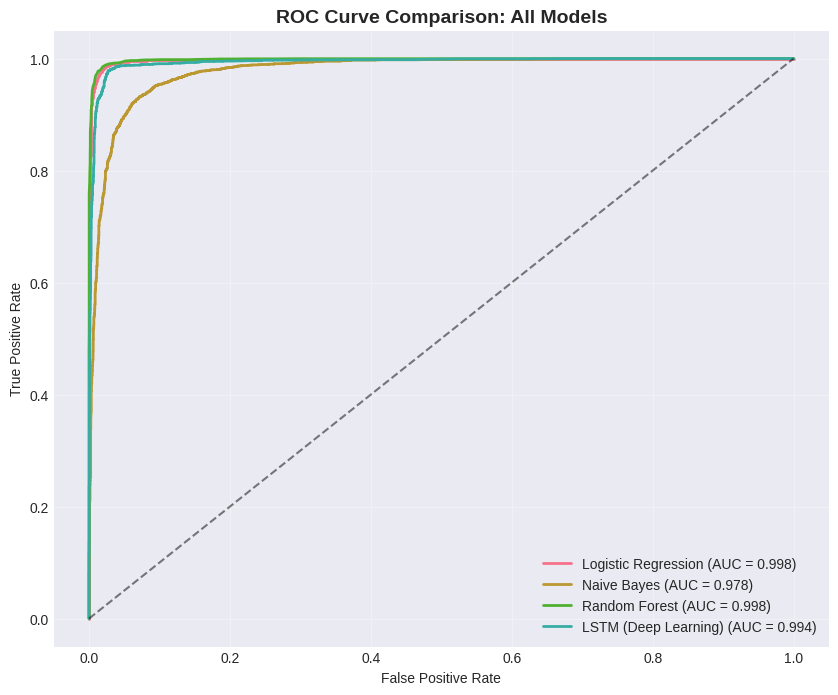


=== Deep Dive into Best Model: Random Forest ===
              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98      4376
        True       0.98      0.98      0.98      4274

    accuracy                           0.98      8650
   macro avg       0.98      0.98      0.98      8650
weighted avg       0.98      0.98      0.98      8650



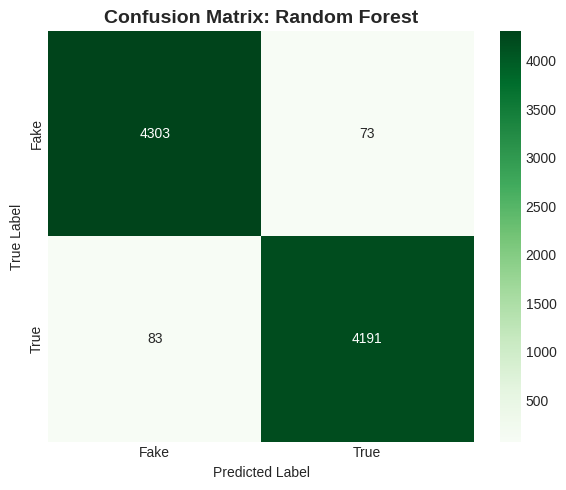


=== Error Analysis (Random Forest) ===
Total Errors: 156 out of 8650 samples (1.80% Error Rate)

[False Positives] Predicted 'True' but actually 'Fake' (Top 2 by confidence):
--- Confidence: 0.8600 ---
barack obama historic visit hiroshima week honour lost world war ii us president said wednesday hours arriving japan group seven summit...
--- Confidence: 0.7600 ---
russia defense ministry investigating whether killed possibly world wanted man isis leader abu bakr albaghdadi among fighters airstrike may albaghdadi death yet verified also first time claim demise made claim comes ministry said airstrike targeted military council meeting group defacto capital raqq...

[False Negatives] Predicted 'Fake' but actually 'True' (Top 2 by confidence):
--- Confidence: 0.0000 ---
...
--- Confidence: 0.1800 ---
class grew parents grandparents could dream food clothing comfort opportunities china economy surged childhood struggle like previous generations eat bitterness giving generally positive out

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from IPython.display import display

# ------------------------------------------------------------------
# 1. Create a consistent train/test split for ALL models
# ------------------------------------------------------------------
# We use the same random_state to ensure all models see the same data splits
X_text = df['processed_text']
y = df['label']

# Basic split for text data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# Reset indices to align everything neatly for error analysis later
X_test_text_reset = X_test_text.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

print("="*40)
print("PART 4: COMPREHENSIVE MODEL EVALUATION".center(40))
print("="*40)
print(f"Test Set Size: {len(y_test_reset):,} samples")

# ------------------------------------------------------------------
# 2. Prepare Data for Classical Models (TF-IDF)
# ------------------------------------------------------------------
print("\n[1/4] Vectorizing data for classical models...")
# Using 5000 features to keep it comparable to common benchmarks
vectorizer_eval = TfidfVectorizer(max_features=5000)
X_train_vec_eval = vectorizer_eval.fit_transform(X_train_text)
X_test_vec_eval = vectorizer_eval.transform(X_test_text)

# ------------------------------------------------------------------
# 3. Train & Evaluate Classical Models
# ------------------------------------------------------------------
# Define the dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(alpha=0.1), # Using alpha=0.1 based on previous tuning
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
}

metrics_list = []
trained_models = {}

print("[2/4] Training and evaluating classical models...")
for name, clf in models.items():
    # Train
    clf.fit(X_train_vec_eval, y_train)
    trained_models[name] = clf

    # Predict labels
    y_pred = clf.predict(X_test_vec_eval)

    # Get probability scores for ROC/AUC (handle models that might not have predict_proba)
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_test_vec_eval)[:, 1]
    else:
        y_scores = clf.decision_function(X_test_vec_eval)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", pos_label=1)

    try:
        roc = roc_auc_score(y_test, y_scores)
    except ValueError:
        roc = 0.5 # Default if AUC cannot be calculated

    metrics_list.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "y_pred": y_pred,     # Store for later analysis
        "y_scores": y_scores  # Store for plotting
    })
    print(f"  -> {name} done (Acc: {acc:.4f})")

# ------------------------------------------------------------------
# 4. Evaluate LSTM Model (from Part 2)
# ------------------------------------------------------------------
print("\n[3/4] Evaluating LSTM model...")

# Check if LSTM artifacts exist in the current environment
if 'model' in locals() and 'tokenizer' in locals() and 'max_len' in locals():
    # Prepare test data for LSTM (using same X_test_text split)
    test_sequences = tokenizer.texts_to_sequences(X_test_text)
    X_test_lstm = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

    # Generate predictions
    y_scores_lstm = model.predict(X_test_lstm, verbose=0).ravel()
    y_pred_lstm = (y_scores_lstm > 0.5).astype(int)

    # Calculate metrics
    acc_lstm = accuracy_score(y_test, y_pred_lstm)
    prec_lstm, rec_lstm, f1_lstm, _ = precision_recall_fscore_support(y_test, y_pred_lstm, average="binary", pos_label=1)
    roc_lstm = roc_auc_score(y_test, y_scores_lstm)

    metrics_list.append({
        "model": "LSTM (Deep Learning)",
        "accuracy": acc_lstm,
        "precision": prec_lstm,
        "recall": rec_lstm,
        "f1": f1_lstm,
        "roc_auc": roc_lstm,
        "y_pred": y_pred_lstm,
        "y_scores": y_scores_lstm
    })
    print(f"  -> LSTM done (Acc: {acc_lstm:.4f})")
else:
    print("  ! LSTM model variables not found in memory. Skipping LSTM evaluation.")

# ------------------------------------------------------------------
# 5. Comparative Visualization & Error Analysis
# ------------------------------------------------------------------
print("\n[4/4] Generating comparative plots and reports...")

# Create Metrics DataFrame
metrics_df = pd.DataFrame(metrics_list)
# Create a display version without the raw prediction data columns
metrics_display = metrics_df[["model", "accuracy", "precision", "recall", "f1", "roc_auc"]].set_index("model").sort_values("f1", ascending=False)

print("\n=== FINAL PERFORMANCE LEADERBOARD ===")
display(metrics_display.style.format("{:.4f}").background_gradient(cmap='Greens'))

# A. ROC Curve Comparison
plt.figure(figsize=(10, 8))
for m in metrics_list:
    fpr, tpr, _ = roc_curve(y_test, m['y_scores'])
    plt.plot(fpr, tpr, label=f"{m['model']} (AUC = {m['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('fig_final_roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# B. Best Model Deep Dive
best_model_name = metrics_display.index[0]
best_model_data = next(item for item in metrics_list if item["model"] == best_model_name)

print(f"\n=== Deep Dive into Best Model: {best_model_name} ===")
print(classification_report(y_test, best_model_data['y_pred'], target_names=['Fake', 'True']))

# Confusion Matrix for Best Model
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, best_model_data['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix: {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# C. Error Analysis (False Positives/Negatives)
# Create a dataframe of errors using the reset indices
error_df = pd.DataFrame({
    'text': X_test_text_reset,
    'true': y_test_reset,
    'pred': best_model_data['y_pred'],
    'prob': best_model_data['y_scores']
})

# Filter for errors
# False Positive: Predicted True (1), Actually Fake (0)
fp = error_df[(error_df['true'] == 0) & (error_df['pred'] == 1)]
# False Negative: Predicted Fake (0), Actually True (1)
fn = error_df[(error_df['true'] == 1) & (error_df['pred'] == 0)]

print(f"\n=== Error Analysis ({best_model_name}) ===")
print(f"Total Errors: {len(fp) + len(fn)} out of {len(y_test)} samples ({100 - best_model_data['accuracy']*100:.2f}% Error Rate)")

if not fp.empty:
    print(f"\n[False Positives] Predicted 'True' but actually 'Fake' (Top 2 by confidence):")
    # Sort by how confident the model was (higher prob means it was more wrong)
    for i, row in fp.sort_values('prob', ascending=False).head(2).iterrows():
        print(f"--- Confidence: {row['prob']:.4f} ---")
        print(f"{row['text'][:300]}...")
else:
    print("\nNo False Positives found!")

if not fn.empty:
    print(f"\n[False Negatives] Predicted 'Fake' but actually 'True' (Top 2 by confidence):")
    # Sort by confidence (lower prob means it was very sure it was 0/Fake)
    for i, row in fn.sort_values('prob', ascending=True).head(2).iterrows():
        print(f"--- Confidence: {row['prob']:.4f} ---")
        print(f"{row['text'][:300]}...")
else:
    print("\nNo False Negatives found!")